In [1]:
#  Imports

import os, pickle, time

import numpy as np
import tensorflow as tf

from keras.layers      import Dense, Input, LeakyReLU
from keras.models      import Model
from keras.callbacks   import EarlyStopping
from keras.optimizers  import Adam, SGD, Adadelta

from matplotlib import pyplot as plt


In [2]:
#  Config

load_models = True

num_hidden_layers   = []
num_nodes_per_layer = []
ensemble_size       = 3

num_datapoints = int(2e3)

random_seed = 100

epochs     = 1000
batch_size = 50
    
model_configs = []
for num_layers in num_hidden_layers :
    assert num_layers >= 0
    if num_layers == 0 :
        model_configs.append((0, 0))
    else :
        for num_nodes in num_nodes_per_layer :
            assert num_nodes > 0
            model_configs.append((num_layers, num_nodes))
            
model_configs.append((100, 50))
model_configs.append((3, 10000))


In [3]:
#  Generate toy data

def true_func (x) :
    x = x*10
    return ((5. + 15.*np.sin(3.*x) + 6*x  + 1.*x*x) - 62.5) / 80.

def sample (num_pts, precision=0.01) :
    np.random.seed(random_seed)
    x = np.random.uniform(low=-1, high=1., size=(num_pts,))
    y = true_func(x)
    u = 3.*np.random.normal(size=(num_pts,))/80.
    return np.array([x, y + u]).transpose()
    
true_data = sample(num_datapoints)

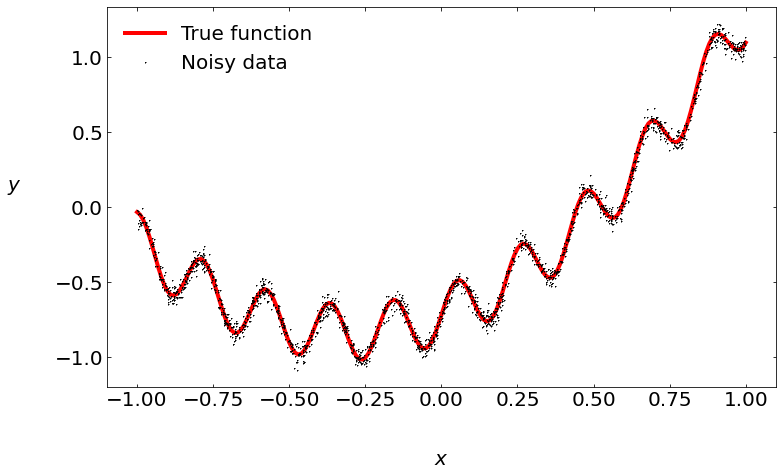

In [4]:
#  Plot toy data

x = np.linspace(-1, 1, 201)
y = true_func(x)

fig = plt.figure(figsize=(12, 7))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(x, y, "-", c="red", lw=4, label="True function")
ax.plot(true_data[:,0], true_data[:,1], "+", c="k", markersize=1, label="Noisy data")
ax.set_xlabel("$x$", fontsize=20, labelpad=40)
ax.set_ylabel("$y$", fontsize=20, labelpad=40, rotation=0)
ax.legend(loc="upper left", fontsize=20, frameon=False)
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=20)
plt.show()


In [5]:
#  Create ensemble of models

models = {}
for model_config in model_configs :
    num_layers, num_nodes = model_config
    models[model_config] = []
    for model_idx in range(ensemble_size) :
        input_layer = Input(1)
        output_layer = input_layer
        for layer_idx in range(num_layers) :
            output_layer = Dense    (num_nodes)(output_layer)
            output_layer = LeakyReLU(0.2)                                 (output_layer)
        output_layer = Dense(1, activation="linear")(output_layer)
        model = Model(input_layer, output_layer, name=f"Model_{num_layers}layers_{num_nodes}nodes_ensemble{1+model_idx}of{ensemble_size}")
        model.compile(loss="mse", optimizer=Adam(lr=1e-4))
        model.summary()
        models[model_config].append(model)
    

Model: "Model_100layers_50nodes_ensemble1of3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                100       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (

Model: "Model_100layers_50nodes_ensemble2of3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_101 (Dense)            (None, 50)                100       
_________________________________________________________________
leaky_re_lu_100 (LeakyReLU)  (None, 50)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_101 (LeakyReLU)  (None, 50)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_102 (LeakyReLU)  (

Model: "Model_100layers_50nodes_ensemble3of3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_202 (Dense)            (None, 50)                100       
_________________________________________________________________
leaky_re_lu_200 (LeakyReLU)  (None, 50)                0         
_________________________________________________________________
dense_203 (Dense)            (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_201 (LeakyReLU)  (None, 50)                0         
_________________________________________________________________
dense_204 (Dense)            (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_202 (LeakyReLU)  (

Model: "Model_3layers_10000nodes_ensemble1of3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_303 (Dense)            (None, 10000)             20000     
_________________________________________________________________
leaky_re_lu_300 (LeakyReLU)  (None, 10000)             0         
_________________________________________________________________
dense_304 (Dense)            (None, 10000)             100010000 
_________________________________________________________________
leaky_re_lu_301 (LeakyReLU)  (None, 10000)             0         
_________________________________________________________________
dense_305 (Dense)            (None, 10000)             100010000 
_________________________________________________________________
leaky_re_lu_302 (LeakyReLU)  

In [6]:
#  Define method for plotting an ensemble of models

def plot_model_ensembles(num_layers, num_nodes, model_list) :
    x = np.linspace(-1, 1, 201)

    fig = plt.figure(figsize=(12, 7))
    ax  = fig.add_subplot(1, 1, 1)

    for model_idx, model in enumerate(model_list) :
        y    = model.predict(x)
        ax.plot(x, y, "-", lw=4, alpha=0.5, label=f"Model {1+model_idx} of {ensemble_size}")

    ax.plot(true_data[:,0], true_data[:,1], "+", c="k", markersize=1, label="Noisy data")
    ax.set_xlabel("$x$", fontsize=20, labelpad=40)
    ax.set_ylabel("$y$", fontsize=20, labelpad=40, rotation=0)
    ax.set_ylim([-1.5, 1.5])
    ax.legend(loc="upper left", fontsize=16, frameon=False)
    ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=20)
    ax.set_title(f"{num_layers} layers, {num_nodes} nodes/layer", fontsize=16, weight="bold")
    plt.savefig(f"network_complexity_test_{num_layers}layers_{num_nodes}nodes_ensemble{ensemble_size}.pdf")
    plt.show()

Training model Model_100layers_50nodes_ensemble1of3
Epoch 1/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.4091
Epoch 2/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3414
Epoch 3/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3322
Epoch 4/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.3325
Epoch 5/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3321
Epoch 6/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3324
Epoch 7/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3324
Epoch 8/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3345
Epoch 9/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.3324
Epoch 10/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3331
Epoch 11/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3325
Epoch 12/1000
40/40 [==============================] - 

40/40 [==============================] - 0s 6ms/step - loss: 0.3323
Epoch 33/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3324
Epoch 34/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3324
Epoch 35/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3322
Epoch 36/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.3324
Epoch 37/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3325
Epoch 38/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3324
Epoch 39/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3327
Epoch 40/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3330
Epoch 41/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.3321
Epoch 42/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3323
Epoch 43/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.3322
Epoch 44/1000
40/40 [=========

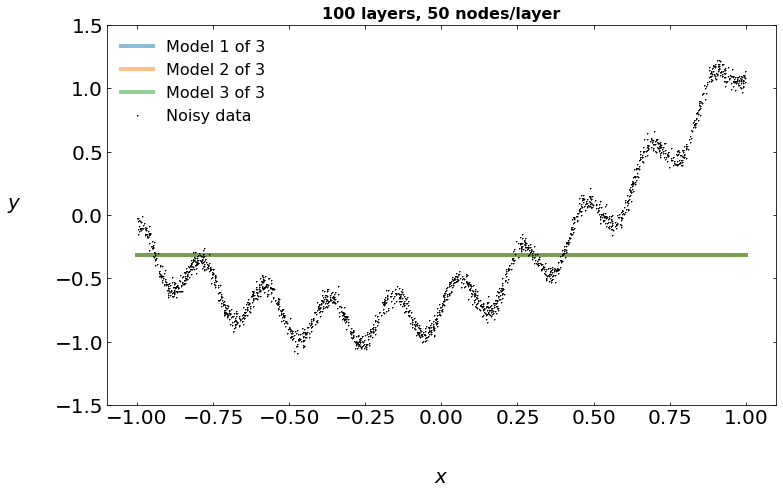

Training model Model_3layers_10000nodes_ensemble1of3
Epoch 1/1000
40/40 [==============================] - 56s 1s/step - loss: 0.1235
Epoch 2/1000
40/40 [==============================] - 48s 1s/step - loss: 0.0309
Epoch 3/1000
40/40 [==============================] - 61s 2s/step - loss: 0.0241
Epoch 4/1000
40/40 [==============================] - 366s 9s/step - loss: 0.0212
Epoch 5/1000
40/40 [==============================] - 134s 3s/step - loss: 0.0193
Epoch 6/1000
40/40 [==============================] - 60s 1s/step - loss: 0.0219
Epoch 7/1000
40/40 [==============================] - 44s 1s/step - loss: 0.0208
Epoch 8/1000
40/40 [==============================] - 40s 1s/step - loss: 0.0205
Epoch 9/1000
40/40 [==============================] - 40s 1s/step - loss: 0.0186
Epoch 10/1000
40/40 [==============================] - 40s 988ms/step - loss: 0.0198
Epoch 11/1000
40/40 [==============================] - 39s 987ms/step - loss: 0.0194
Epoch 12/1000
40/40 [=========================

KeyboardInterrupt: 

In [7]:
#  Train ensemble of models

for model_config, model_list in models.items() :
    for model in model_list :
        do_fit = not load_models
        if load_models :
            model_fname = f".{model.name}.params"
            if os.path.exists(f"{model_fname}.index") :
                print(f"Loading model {model.name} from file {model_fname}")
                model.load_weights(model_fname)
            else :
                do_fit = True
        if do_fit :
            print(f"Training model {model.name}")
            model.fit(true_data[:,0], 
                      true_data[:,1], 
                      epochs           = epochs                   , 
                      shuffle          = True                     ,
                      batch_size       = batch_size               ,
                      callbacks = [EarlyStopping(patience=20, restore_best_weights=True, monitor="loss", min_delta=0)]
                     )
    plot_model_ensembles(model_config[0], model_config[1], model_list)
    

In [ ]:
#  Save models

if not load_models :
    for model_config, model_list in models.items() :
        for model in model_list :
            model_fname = f".{model.name}.params"
            model.save_weights(model_fname)

In [ ]:
#  Plot ensembles of models

for model_config, model_list in models.items() :
    num_layers, num_nodes = model_config
    plot_model_ensembles(num_layers, num_nodes, model_list)


In [ ]:
num_layers = 3
num_nodes  = 3

In [ ]:

def activation (x) :
    if type(x) == np.ndarray : return np.array([activation(xp) for xp in x])
    if x < 0 : return 0.2*x
    return x
    
weights, biases = [], []
prev_dim = 1
for l in range(num_layers) :
    weight = np.random.uniform(low=-1, high=1, size=(num_nodes, prev_dim)) * 3. / np.sqrt(prev_dim)
    bias   = np.random.uniform(low=-1, high=1, size=(num_nodes,))
    weights.append(weight)
    biases .append(bias  )
    prev_dim = num_nodes
    
weights.append(np.random.uniform(low=-0.5, high=0.5, size=(1, prev_dim)))
biases .append(np.random.uniform(low=-0.5, high=0.5, size=(1,)))
    
def fwd (x) :
    if type(x) == np.ndarray : return np.array([fwd(xp) for xp in x])
    x = np.array([x,])
    for l in range(num_layers+1) :
        x = np.matmul(weights[l], x) + biases[l]
        x = activation(x)
    return x


In [ ]:
x = np.linspace(-4, 4, 2001)

y = fwd(x)

fig = plt.figure(figsize=(10, 3))
plt.plot(x, y, "-")
plt.show()

fig = plt.figure(figsize=(10, 3))
plt.plot(0.5*(x[1:]+x[:-1]), y[1:]-y[:-1], "-")
plt.show()


In [ ]:
print((2*num_nodes) ** num_layers)